# BGS Tiles observed as of
January 29, 2020

In [1]:
import os 
import glob
import h5py
import ephem
import fitsio
import numpy as np 
import pylab as pl

from desimodel.io import load_tiles
from astropy.time import Time, TimeDelta
from astropy.table import Table
from desimodel.footprint import is_point_in_desi
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
# local directory with data
dat_dir    = '/global/cfs/cdirs/desi/users/chahah/'

# Read parent DESI tile

In [3]:
# pick the rest of the tiles from desi-tiles.fits far from the selected tiles 
desi_tiles = load_tiles(onlydesi=False)

imaging    = Table(desi_tiles[desi_tiles['IN_IMAGING'] == 1], copy=True)
imaging    = imaging[imaging['PASS'] == 5]['RA', 'DEC']

desi_tiles = desi_tiles[desi_tiles['PASS'] == 5]
desi_tiles = desi_tiles[desi_tiles['IN_DESI'] == 1]

# Read moon positions starting Jan 1, 2020

In [4]:
def get_moons():
    moon  = ephem.Moon()

    start = Time('2020-01-01', format='iso')
    moons = []

    for day in range(365):
        night = start + day * TimeDelta(1., format='jd')
        night = night.isot.replace('-', '/').replace('T',' ').split('.')[0]
    
        moon.compute(night)
        moons.append([moon.ra, moon.dec])
    
    moons       = np.array(moons)
    moons[:,0] *= 180. / np.pi
    moons[:,1] *= 180.
    
    return moons

In [5]:
moons = get_moons()

# Lets read in the potential SV regions
starting with
## Abell cluster fields within DESI

In [6]:
abell = Table.read('../../py/bgs_sv/dat/abell.dat', format='ascii', names=['Name', 'RA', 'DEC']) 
isin = is_point_in_desi(imaging, abell['RA'], abell['DEC'], return_tile_index=False)
print('%i of %i Abell fields are within the DESI footprint' % (np.sum(isin), len(isin)))

24 of 29 Abell fields are within the DESI footprint


In [7]:
abell = abell[isin]

## DES supernovae fields

In [8]:
des_sn = Table.read('../../py/bgs_sv/dat/des-supernovae.dat', format='ascii', names=['FIELD', 'RA', 'DEC', 'DEPTH']) 

In [9]:
des_sn

FIELD,RA,DEC,DEPTH
str2,float64,float64,str7
X1,34.4757,-4.9295,shallow
X2,35.6645,-6.4121,shallow
X3,36.45,-4.6,deep
S1,42.82,0.0,shallow
S2,41.1944,-0.9884,shallow


## SV fields in Table 2 of SV document
These are fields that span the three imaging catalogs, regions with overlapping imaging, regions with truth tables, bad seeing conditions, etc. 

In [10]:
sv_regions = Table.read('../../py/bgs_sv/dat/sv_fields.dat', format='ascii') 

In [11]:
sv_regions

col1,col2,col3,col4,col5
str3,float64,float64,float64,float64
ngc,187.0,191.0,61.0,63.0
ngc,210.0,220.0,50.0,55.0
ngc,215.0,230.0,41.0,46.0
ngc,260.0,280.0,60.0,70.0
ngc,129.0,141.0,-2.0,3.0
ngc,149.0,151.0,1.2,3.2
ngc,174.0,186.0,-3.0,2.0
ngc,211.0,224.0,-2.0,3.0
sgc,-5.0,5.0,15.0,20.0


In [12]:
def plot_context(sub, label=True): 
    # DESI tiles
    sub.scatter(desi_tiles['RA'], desi_tiles['DEC'], s=2, alpha=0.5, c='k')
    sub.scatter(imaging['RA'], imaging['DEC'], s=2, alpha=0.1, c='k')

    # Moon positions
    sub.scatter(moons[:,0], moons[:,1], c='C1', alpha=0.8, s=2, label=[None, 'moon'][label])

    # Abell clusters
    #sub.scatter(abell['RA'], abell['DEC'], c='C2', s=15, label=[None, 'Abell'][label])
    
    # DES SN fields
    #sub.scatter(des_sn['RA'], des_sn['DEC'], c='C3', s=15, label=[None, 'DES SN'][label], zorder=10)
    
    # SV regions
    if label: 
        region = patches.Rectangle((0,0),0,0, linewidth=1, facecolor='C0', alpha=0.5, label='SV fields')
        sub.add_patch(region) 
    for sv_region in sv_regions: 
        ra_min, ra_max, dec_min, dec_max = sv_region[1], sv_region[2], sv_region[3], sv_region[4]
        region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), linewidth=1, facecolor='C0', alpha=0.5)
        sub.add_patch(region) 
    return None

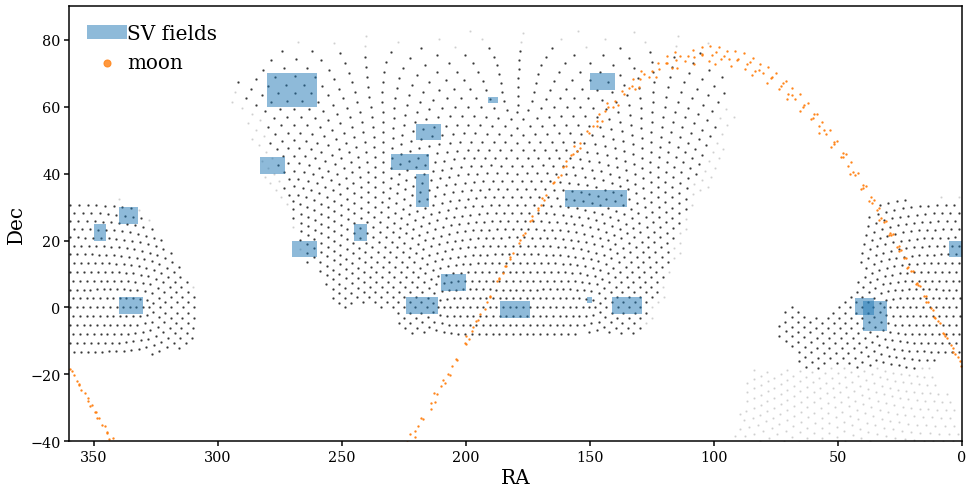

In [13]:
fig = plt.figure(figsize=(16,8))
sub = fig.add_subplot(111)

plot_context(sub, label=True)

sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)
sub.legend(loc='upper left', fontsize=20, handletextpad=0., markerscale=5)

# Regions we want *outside* of proposed SV fields

In [14]:
omitted_regions = {}
omitted_regions['PRIMUS-COSMOS']     = np.array([149.6, 150.7, 1.8, 2.9])
omitted_regions['PRIMUS-CDFS-SWIRE'] = np.array([51.8, 54.4, -29.7, -28.0])

In [15]:
def plot_omitted(sub, label=False): 
    # omitted region
    for i, reg in enumerate(omitted_regions.keys()): 
        ra_min, ra_max, dec_min, dec_max = omitted_regions[reg]
        region = patches.Rectangle((ra_min, dec_min), (ra_max - ra_min), (dec_max - dec_min), facecolor='C0', label=[None, reg][label])
        sub.add_patch(region)     
    return None

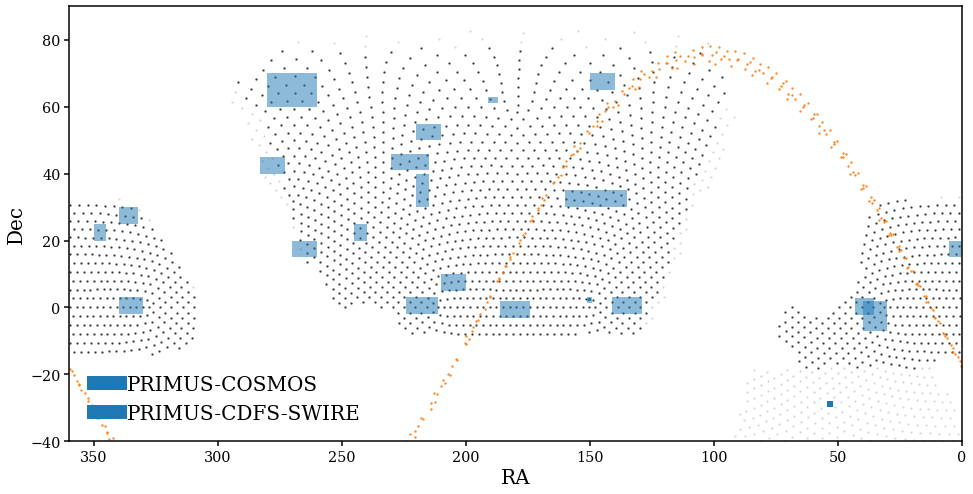

In [16]:
fig = plt.figure(figsize=(16,8))
sub = fig.add_subplot(111)

plot_context(sub, label=False)
plot_omitted(sub, label=True)

sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)
sub.legend(loc='lower left', fontsize=20, handletextpad=0., markerscale=5)

# Lets see where the SV1 tiles observed so far lie
https://data.desi.lbl.gov/desi/survey/observations/SV1/sv1-html/index.html

In [17]:
from bgs_sv import sv1
import astropy.table as atable
exps = sv1.sv1_exposures()

In [18]:
exps[:5]

NIGHT,EXPID,TILEID,TILERA,TILEDEC,EXPTIME,MJDOBS,FIELD,TARGETS,EBV,SPECMODEL_SKY_RMAG_AB,NGFA,B_DEPTH,R_DEPTH,Z_DEPTH,TGT,SKY,STD,WD,LRG,ELG,QSO,BGS,MWS,GFA_AIRMASS_MIN,GFA_AIRMASS_MEAN,GFA_AIRMASS_MED,GFA_AIRMASS_MAX,GFA_MOON_ILLUMINATION_MIN,GFA_MOON_ILLUMINATION_MEAN,GFA_MOON_ILLUMINATION_MED,GFA_MOON_ILLUMINATION_MAX,GFA_MOON_ZD_DEG_MIN,GFA_MOON_ZD_DEG_MEAN,GFA_MOON_ZD_DEG_MED,GFA_MOON_ZD_DEG_MAX,GFA_MOON_SEP_DEG_MIN,GFA_MOON_SEP_DEG_MEAN,GFA_MOON_SEP_DEG_MED,GFA_MOON_SEP_DEG_MAX,GFA_TRANSPARENCY_MIN,GFA_TRANSPARENCY_MEAN,GFA_TRANSPARENCY_MED,GFA_TRANSPARENCY_MAX,GFA_FWHM_ASEC_MIN,GFA_FWHM_ASEC_MEAN,GFA_FWHM_ASEC_MED,GFA_FWHM_ASEC_MAX,GFA_SKY_MAG_AB_MIN,GFA_SKY_MAG_AB_MEAN,GFA_SKY_MAG_AB_MED,GFA_SKY_MAG_AB_MAX,GFA_FIBER_FRACFLUX_MIN,GFA_FIBER_FRACFLUX_MEAN,GFA_FIBER_FRACFLUX_MED,GFA_FIBER_FRACFLUX_MAX,GFA_FIBER_FRACFLUX_ELG_MIN,GFA_FIBER_FRACFLUX_ELG_MEAN,GFA_FIBER_FRACFLUX_ELG_MED,GFA_FIBER_FRACFLUX_ELG_MAX,GFA_TRANSPFRAC_MIN,GFA_TRANSPFRAC_MEAN,GFA_TRANSPFRAC_MED,GFA_TRANSPFRAC_MAX
int64,int64,int64,float32,float32,float32,float32,bytes30,bytes8,float32,float32,int64,float32,float32,float32,int64,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
20201214,67710,80605,36.448,-4.601,900.077,59198.176,XMM-LSS,QSO+LRG,0.03,21.3786,112,23.6,21.1,22.9,4200,800,136,13,2117,1341,1428,464,191,1.2451736,1.2460719,1.2457608,1.2481316,0.0035338968,0.003620759,0.0036200895,0.0037041577,132.15999,134.03085,134.0164,135.81998,119.153725,119.157166,119.15722,119.15745,0.69070935,0.86158174,0.8766086,0.9415948,2.7681437,3.4177191,3.3609707,4.347182,20.444715,20.36623,20.365633,20.29731,0.06531224,0.10122263,0.10227376,0.14149179,0.06263497,0.09392171,0.09485156,0.12780459,0.046559494,0.08796106,0.08944121,0.13066149
20201214,67711,80605,36.448,-4.601,900.064,59198.188,XMM-LSS,QSO+LRG,0.03,21.37746,110,21.1,18.7,20.0,4200,800,136,13,2117,1341,1428,464,191,1.249222,1.2545534,1.2542566,1.2608744,0.0037303115,0.0038198214,0.0038198896,0.0039052614,136.1901,138.07304,138.0778,139.8561,118.960846,118.96445,118.96448,118.96475,0.647927,0.84916604,0.85969776,0.94794995,2.6857412,3.5251822,3.5365777,4.498588,20.482286,20.407803,20.41952,20.25393,0.06309073,0.09657361,0.09301873,0.14835781,0.060335778,0.08994521,0.087079056,0.13311633,0.040878184,0.082993776,0.07898156,0.13812387
20201214,67712,80605,36.448,-4.601,900.056,59198.203,XMM-LSS,QSO+LRG,0.03,21.375774,107,40.2,35.2,38.1,4200,800,136,13,2117,1341,1428,464,191,1.2625953,1.2724212,1.2721153,1.2830926,0.0039242916,0.0040158313,0.004015748,0.004103366,140.07759,141.96028,141.96542,143.74316,118.77728,118.78134,118.78137,118.78176,0.64363074,0.89567786,0.911151,0.9656678,2.2947626,3.0399861,2.954046,4.416968,20.504004,20.402893,20.404596,20.292088,0.06389628,0.12599923,0.12637429,0.19364204,0.061270714,0.114351034,0.11548514,0.16844937,0.04112561,0.11421667,0.11708183,0.18699387
20201214,67713,80605,36.448,-4.601,900.004,59198.215,XMM-LSS,QSO+LRG,0.03,21.399988,106,52.7,47.8,53.4,4200,800,136,13,2117,1341,1428,464,191,1.2859056,1.3007282,1.3004993,1.3160986,0.0041234763,0.0042179334,0.00421871,0.004306803,143.97894,145.87181,145.8889,147.63985,118.59419,118.598274,118.59832,118.59852,0.7015471,0.927819,0.9349743,0.9889291,2.262067,2.8427548,2.7889047,4.427774,20.615604,20.374401,20.369755,20.291533,0.063534044,0.14013442,0.13994345,0.1952197,0.061012335,0.12617795,0.12590359,0.1698058,0.044572122,0.13092393,0.12895063,0.19069208
20201214,67733,80606,36.448,-4.501,900.026,59198.246,XMM-LSS,ELG,0.03,21.359089,103,128.2,119.3,134.4,4198,800,136,10,8,4060,201,10,131,1.3752754,1.4031851,1.4027501,1.4317049,0.0045783324,0.00467682,0.004676891,0.0047707567,152.5133,154.36719,154.37445,156

In [19]:
bgs_exps = exps[exps['TARGETS'] == 'BGS+MWS']
print('%i BGS+MWS exposures' % len(bgs_exps))

357 BGS+MWS exposures


In [20]:
bgs_tiles = atable.unique(bgs_exps['TILEID', 'TILERA', 'TILEDEC'], keys='TILEID')
print('%i BGS tiles' % len(bgs_tiles))

39 BGS tiles


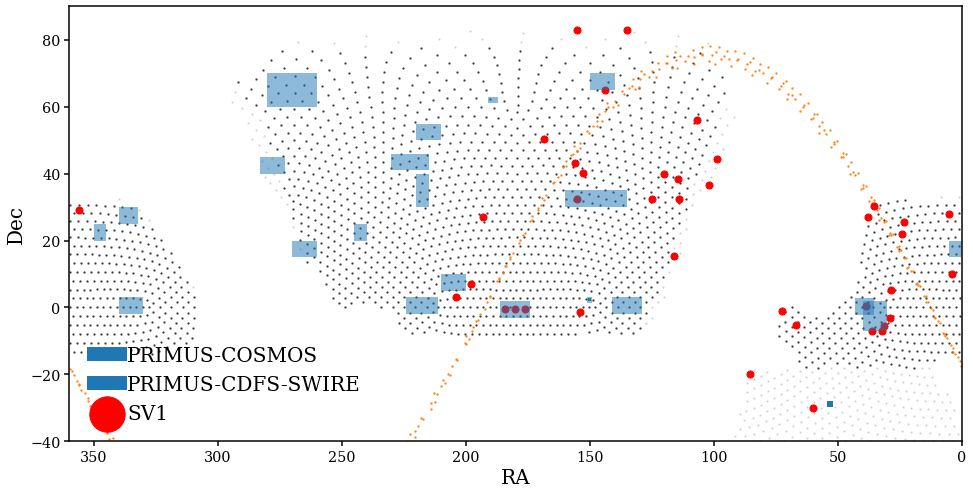

In [29]:
fig = plt.figure(figsize=(16,8))
sub = fig.add_subplot(111)

plot_context(sub, label=False)
plot_omitted(sub, label=True)
sub.scatter(bgs_tiles['TILERA'], bgs_tiles['TILEDEC'], color='r', s=50, label='SV1')

sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)
sub.legend(loc='lower left', fontsize=20, handletextpad=0., markerscale=5)

# designed but not observed tiles

In [30]:
bgs_designed_radec = [
    (17.8, 0.60), 
    (30., -30.),
    (30., 30.),
    (36., -1.5),
    (130.4, -7),
    (132.7, 9.930), 
    (135.0, 32.375),
    (149.319, 37.187),
    (158.128, 10.360), 
    (163.736, 47.858), 
    (165.0, 32.375)
]

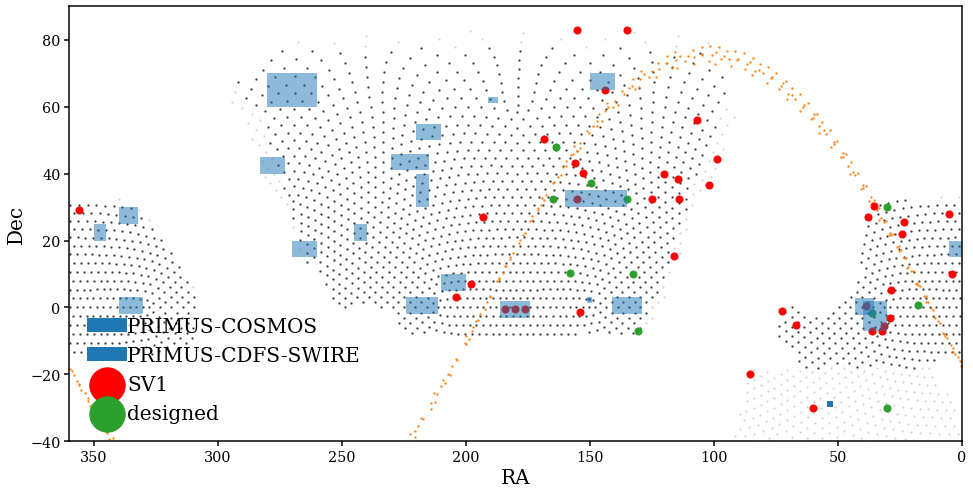

In [31]:
fig = plt.figure(figsize=(16,8))
sub = fig.add_subplot(111)

plot_context(sub, label=False)
plot_omitted(sub, label=True)
sub.scatter(bgs_tiles['TILERA'], bgs_tiles['TILEDEC'], color='r', s=50, label='SV1')
sub.scatter([radec[0] for radec in bgs_designed_radec], [radec[1] for radec in bgs_designed_radec], color='C2', s=50, label='designed')

sub.set_xlabel('RA', fontsize=20)
sub.set_xlim(360, 0)
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim(-40, 90)
sub.legend(loc='lower left', fontsize=20, handletextpad=0., markerscale=5)